In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import ts_ad

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [3]:
log_dir = "./outputs/ts_ad_rmse"

input_len = 120
output_len = 60

horizon = input_len + output_len
stride = output_len

batch_size = 128

num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


In [6]:
train_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_train, horizon=horizon, stride=2*stride), input_len),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    ts_ad.TSADEDataset(data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride), input_len),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
    out_shape=(output_len,)
).float()

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = ts_ad.TSADEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
)


# Training

In [8]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss = 0.851 - test_loss = 0.854 - test_cost=3.413 - test_threshold=9.561 - lr = 1.00e-03


Epoch 1 - train_loss = 0.834 - test_loss = 0.845 - test_cost=3.504 - test_threshold=9.735 - lr = 9.76e-04


Epoch 2 - train_loss = 0.828 - test_loss = 0.835 - test_cost=3.410 - test_threshold=9.799 - lr = 9.05e-04


Epoch 3 - train_loss = 0.820 - test_loss = 0.831 - test_cost=3.457 - test_threshold=9.876 - lr = 7.94e-04


Epoch 4 - train_loss = 0.804 - test_loss = 0.828 - test_cost=3.515 - test_threshold=9.926 - lr = 6.55e-04


Epoch 5 - train_loss = 0.802 - test_loss = 0.840 - test_cost=3.544 - test_threshold=9.988 - lr = 5.00e-04


Epoch 6 - train_loss = 0.821 - test_loss = 0.820 - test_cost=3.434 - test_threshold=9.951 - lr = 3.45e-04


Epoch 7 - train_loss = 0.787 - test_loss = 0.817 - test_cost=3.384 - test_threshold=9.958 - lr = 2.06e-04


Epoch 8 - train_loss = 0.793 - test_loss = 0.817 - test_cost=3.440 - test_threshold=9.957 - lr = 9.55e-05


Epoch 9 - train_loss = 0.797 - test_loss = 0.817 - test_cost=3.453 - test_threshold=9.948 - lr = 2.45e-05


In [9]:
backbone = resnet.ResNetFeatures(
    resnet.Bottleneck,
    resnet.RESNET50_LAYERS,
    num_features=data.NUM_FEATURES,
    return_layers=[resnet.LAYER_1, resnet.LAYER_4],
    replace_stride_with_dilation=[False, True, True],
)

# Evaluating

In [10]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [11]:
# Cost model
cmodel = metrics.default_cmodel()


In [12]:
scores, labels = get_predictions(engine.predict, test_loader)


100%|██████████| 44/44 [00:43<00:00,  1.01it/s]


In [33]:
cmodel.fit(scores, labels).optimize()


(2.091862396895885, 0.20565508)

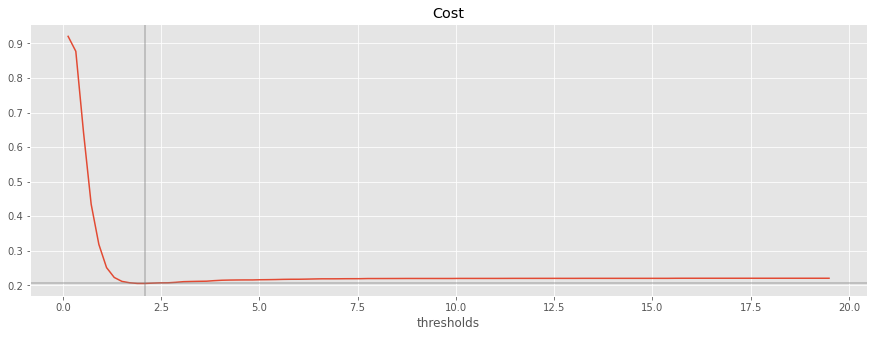

In [34]:
metrics.plot_cost(cmodel)


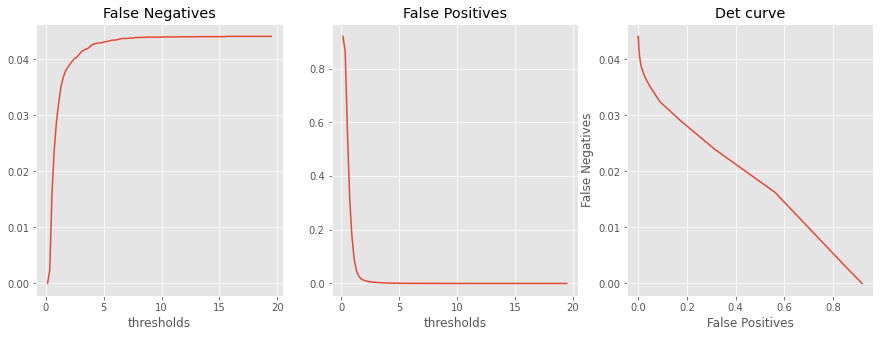

In [35]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


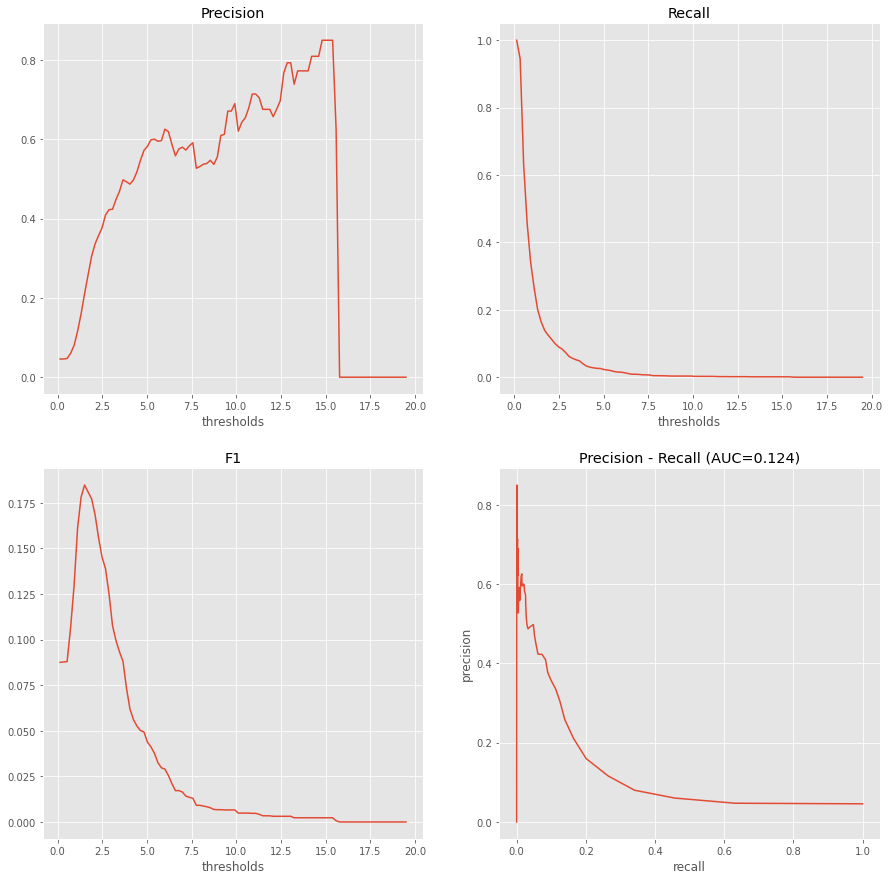

In [36]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)